Shape: (12000, 30)
Target distribution:
 target
0    0.676583
1    0.323417
Name: proportion, dtype: float64
   id     num01     num02     num03     num04     num05     num06     num07  \
0   1 -0.946058 -0.070313  1.824445 -2.754422  0.808865 -0.111094 -0.268950   
1   2 -2.484027  0.739378  1.596908 -2.586479 -0.033225 -3.054412 -4.706908   
2   3  1.522629  7.159635 -0.564903 -4.493110  1.623610  5.450187 -0.974595   
3   4  0.463373 -1.073908  1.752813  0.362786  2.790872  4.082385  0.322283   
4   5  3.188390 -4.701692 -0.689918 -0.448995  0.373821 -3.275363 -1.760931   

      num08     num09  ...     num20     num21     num22     num23     num24  \
0 -3.078210  0.801275  ... -1.616515 -1.989464  1.407390 -0.218362  2.016052   
1 -9.795169  0.145911  ... -1.727040 -0.583997  1.136761  0.285978 -0.310879   
2 -5.189589  1.600591  ...  0.524408  2.022430  1.278358 -0.850547  0.847457   
3  3.390984 -0.033929  ...  2.399834 -1.431576 -0.746987  0.049639  2.414689   
4  0.923689  0.5

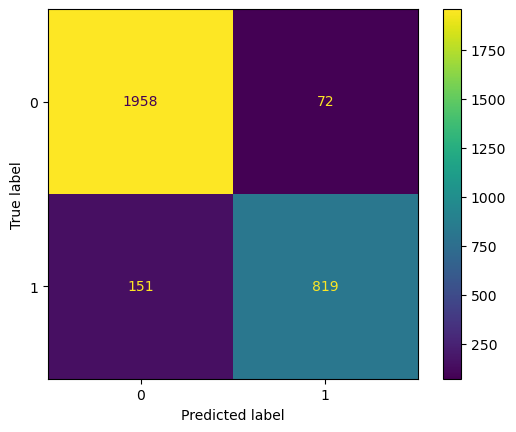

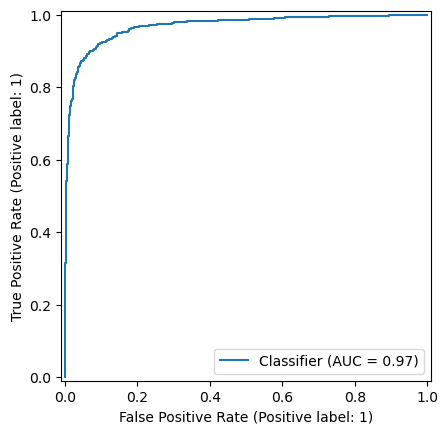

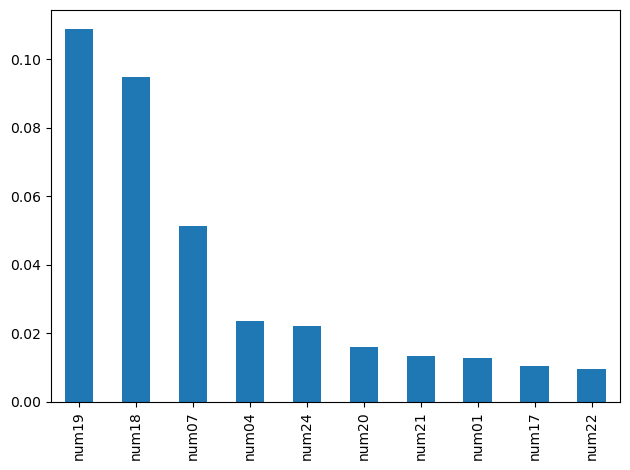

['artifacts\\best_model.joblib']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import joblib
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.inspection import permutation_importance

ARTIFACTS_DIR = "artifacts"
FIGURES_DIR = os.path.join(ARTIFACTS_DIR, "figures")
os.makedirs(FIGURES_DIR, exist_ok=True)

df = pd.read_csv("S06-hw-dataset-01.csv")

print("Shape:", df.shape)
print("Target distribution:\n", df["target"].value_counts(normalize=True))
print(df.head())
print(df.info())
print(df.describe())
print("Missing values:", df.isnull().sum().sum())

X = df.drop(columns=["target", "id"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

results = {}

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
results["Dummy"] = {
    "accuracy": accuracy_score(y_test, dummy.predict(X_test)),
    "f1": f1_score(y_test, dummy.predict(X_test))
}

pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=1000))
])

pipe_lr.fit(X_train, y_train)
lr_pred = pipe_lr.predict(X_test)
lr_proba = pipe_lr.predict_proba(X_test)[:, 1]

results["LogisticRegression"] = {
    "accuracy": accuracy_score(y_test, lr_pred),
    "f1": f1_score(y_test, lr_pred),
    "roc_auc": roc_auc_score(y_test, lr_proba)
}

tree = DecisionTreeClassifier(random_state=42)
tree_grid = {
    "max_depth": [3, 5],
    "min_samples_leaf": [1, 5]
}

gs_tree = GridSearchCV(
    tree,
    tree_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)
gs_tree.fit(X_train, y_train)

rf = RandomForestClassifier(random_state=42)
rf_grid = {
    "n_estimators": [100],
    "max_depth": [5, 10],
    "min_samples_leaf": [1, 5],
    "max_features": ["sqrt"]
}

gs_rf = GridSearchCV(
    rf,
    rf_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)
gs_rf.fit(X_train, y_train)

gb = GradientBoostingClassifier(random_state=42)
gb_grid = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3, 5]
}

gs_gb = GridSearchCV(
    gb,
    gb_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)
gs_gb.fit(X_train, y_train)

models = {
    "DecisionTree": gs_tree.best_estimator_,
    "RandomForest": gs_rf.best_estimator_,
    "GradientBoosting": gs_gb.best_estimator_
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba)
    }

print("\nTEST METRICS")
for k, v in results.items():
    print(k, v)

best_model = max(
    models.values(),
    key=lambda m: roc_auc_score(y_test, m.predict_proba(X_test)[:, 1])
)

ConfusionMatrixDisplay.from_predictions(
    y_test, best_model.predict(X_test)
)
plt.savefig(os.path.join(FIGURES_DIR, "confusion_matrix.png"))
plt.show()

RocCurveDisplay.from_predictions(
    y_test, best_model.predict_proba(X_test)[:, 1]
)
plt.savefig(os.path.join(FIGURES_DIR, "roc_curve.png"))
plt.show()

perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42
)

pd.Series(
    perm.importances_mean,
    index=X_test.columns
).sort_values(ascending=False).head(10).plot.bar()

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "permutation_importance.png"))
plt.show()

with open(os.path.join(ARTIFACTS_DIR, "metrics_test.json"), "w") as f:
    json.dump(results, f, indent=2)

with open(os.path.join(ARTIFACTS_DIR, "search_summaries.json"), "w") as f:
    json.dump(
        {
            "DecisionTree": gs_tree.best_params_,
            "RandomForest": gs_rf.best_params_,
            "GradientBoosting": gs_gb.best_params_
        },
        f,
        indent=2
    )

best_model_name = None
best_roc = -1
for name, model in models.items():
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    if roc > best_roc:
        best_roc = roc
        best_model_name = name

with open(os.path.join(ARTIFACTS_DIR, "best_model_meta.json"), "w") as f:
    json.dump(
        {
            "best_model": best_model_name,
            "best_model_class": type(best_model).__name__,
            "test_metrics": results[best_model_name],
            "selection_criterion": "roc_auc"
        },
        f,
        indent=2
    )
joblib.dump(best_model, os.path.join(ARTIFACTS_DIR, "best_model.joblib"))

